<a href="https://colab.research.google.com/github/avitalkras/Deep-Learning-Project/blob/main/Code_Tutorial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Guide to Neural Net Training

In this tutorial, we'll use PyTorch to implement and run a typical training loop on MNIST.

Let's try see some of the optimization issues and workarounds we've discussed in lecture in action!

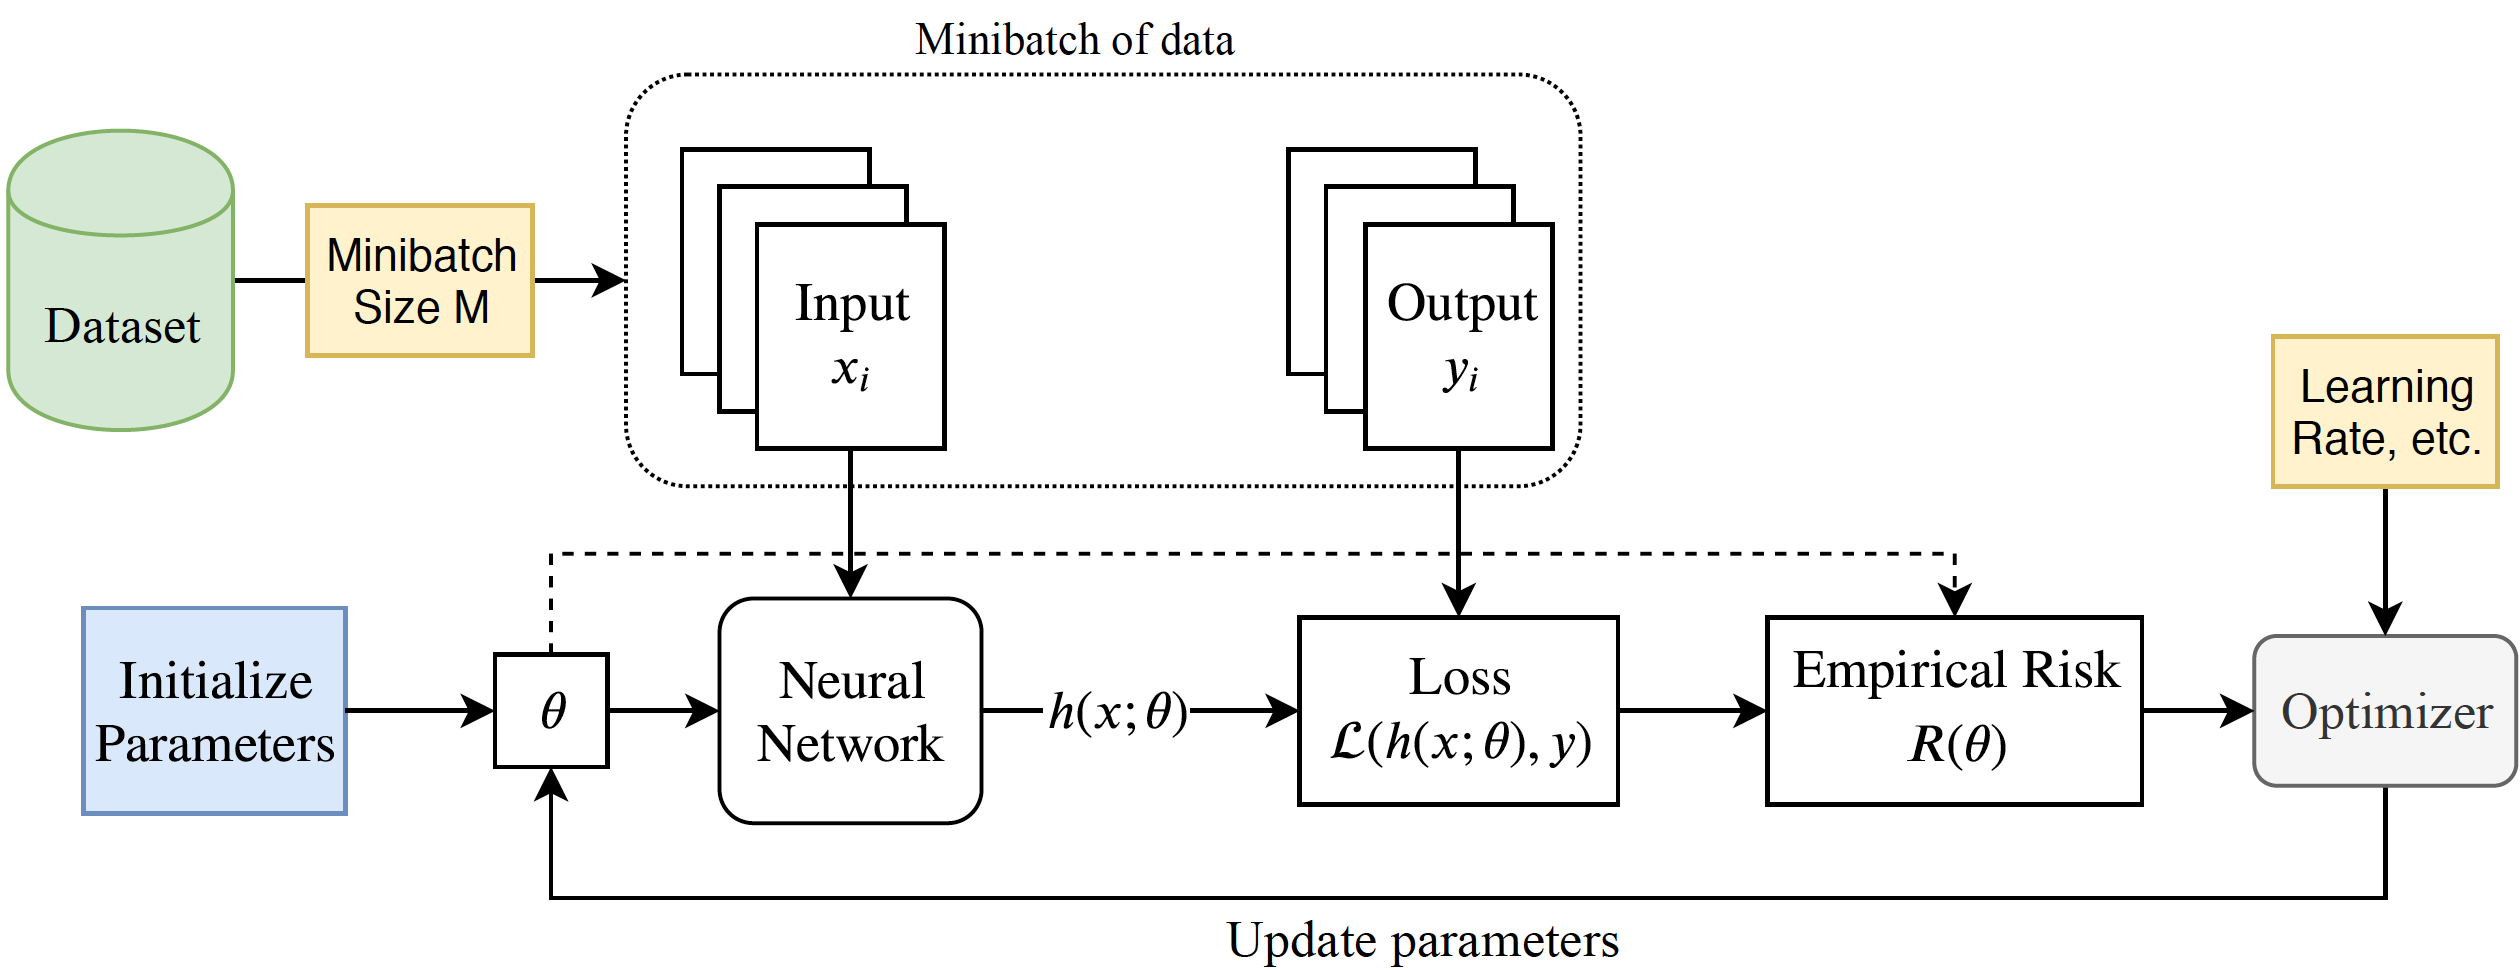

A typical training pipeline roughly consists of the following steps:

* Prepare your dataset. You might want to normalize the data to have zero mean and unit variance., or apply other data augmentations.
* Define your model, loss function, and optimizer, and initialize model parameters.
* Loop until some stopping criteria:
  * Sample a mini-batch of data as inputs.
  * Compute the forward pass of the model with your inputs.
  * Compute the cost function on model predictions and labels.
  * Update model parameters using your optimizer.
* Tune hyperparameters like learning rate, batch size, number of training epochs.

PyTorch modularizes different parts of this pipeline for us, by giving us different objects for the `dataset`, `optimizer`, and `model`. We can easily switch these out and try different combinations!


### Let's first import some useful libraries and set a seed to make our work reproducible.

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Dataset

We will use `torch` to download the training and test data of MNIST. We saw in lecture that it is often useful to normalize the data to have zero mean and unit variance. The `torch.transforms` functionality allows us to apply this function, among others, to the entire dataset.

In [ ]:
train_data = datasets.MNIST(root='.data',
                            train=True,
                            download=True)

test_data = datasets.MNIST(root='.data',
                           train=False,
                           download=True)
print(f'\n')
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')



Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

data_transforms = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[mean], std=[std])
                              ])

train_data = datasets.MNIST(root='.data',
                            train=True,
                            download=True,
                            transform=data_transforms)
test_data = datasets.MNIST(root='.data',
                           train=False,
                           download=True,
                           transform=data_transforms)

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [ ]:
print(type(train_data[0]), len(train_data[0]))
print(type(train_data[0][0]), train_data[0][0].shape)
print(type(train_data[0][1]), train_data[0][1])

<class 'tuple'> 2
<class 'torch.Tensor'> torch.Size([1, 28, 28])
<class 'int'> 5


What does our data look like? Let's write a utility function to show the images and their labels.

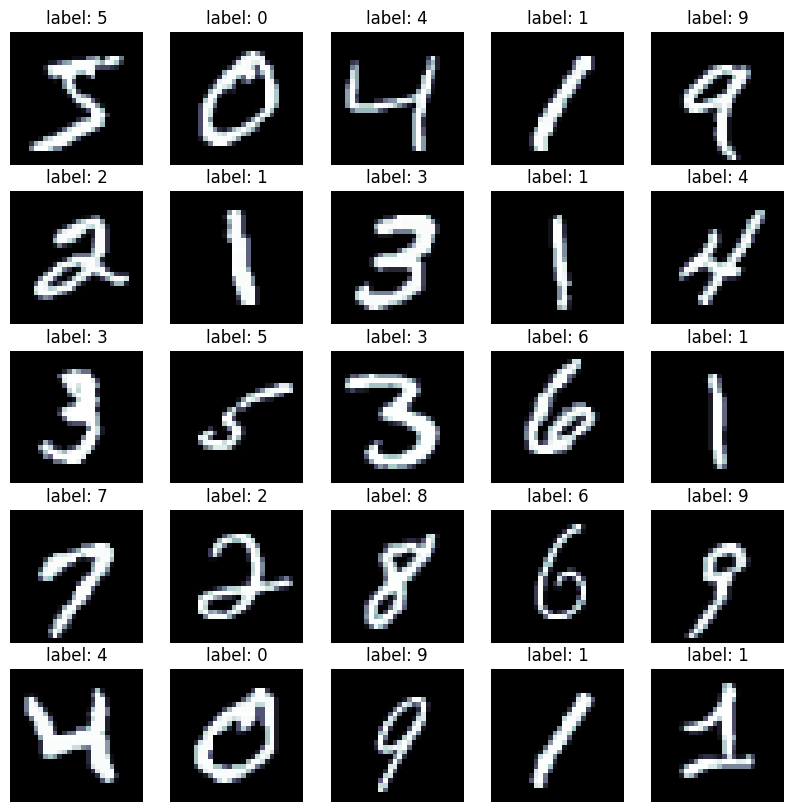

In [ ]:
def plot_images(images, labels):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'label: {labels[i]}')
        ax.axis('off')

N_IMAGES = 25
images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
labels = [label for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images, labels)

### Model

Now, we can use `torch` modules to define our model. Let's start with a 3-layer fully connected network. Since MNIST has 28 x 28 images, it needs to take 28*28 input dimensions. Since there are 10 possible categories for the labels, it must have output dimension of 10. The number of hidden units in each layer can be treated as a hyperparameter.

Note that we need to define a `forward` function which will execute the forward pass. But PyTorch with handle backpropagation for us automatically!

In [ ]:
class FCNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc = nn.Linear(128, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]

        h_1 = self.input_fc(x)
        # h_1 = [batch size, 128]

        h_2 = self.hidden_fc(h_1)
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred


INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
model = FCNet(INPUT_DIM, OUTPUT_DIM)

How many parameters (weights + biases) does this network have? Can you compute this analytically?

We can also write the following function to check which parameters require gradients and count them. Make sure the number it gives matches what you expect.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 114,390 trainable parameters


### Training

Now, let's finally write the training loop. During training, we would like to keep track of some metrics other than the loss, for instance classification accuracy. So here, we write a helper function to compute accuracy, a train function to loop through the dataset and update model parameters using an optimizer, and an evaluate function to evaluate our trained network.

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train() # set the model to be in "training" mode: recall why this might be important, for instance, if the network has a Dropout layer

    for (x, y) in tqdm(iterator, desc="Training", leave=False): # sample a mini-batch

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad() # zero out all gradients tracked by your optimizer

        y_pred = model(x) # run the forward pass: under the hood, this calls your model's `forward` function
        loss = criterion(y_pred,y) # compute the loss

        acc = calculate_accuracy(y_pred, y) # calculate training accuracy on this batch

        loss.backward() # backpropagate gradients of the loss with respect to parameters
        optimizer.step() # update network parameters

        epoch_loss += loss.item() # track training loss
        epoch_acc += acc.item() # track training accuracy

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad(): # use this so that no gradients are computed since we won't update the model during evaluation

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Putting everything together

Let's define some hyperparameters: learning rate, number of epochs, and batch size. We'll use the SGD optimizer and Cross-entropy loss.

In [ ]:
LR = 0.01
EPOCHS = 10
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data,
                                shuffle=True,
                                batch_size=BATCH_SIZE)

def run(model, train_iterator, epochs, lr):

  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)
  criterion = criterion.to(device)

  for epoch in trange(epochs):
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

      print(f'Epoch: {epoch+1:02} ')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

run(model, train_iterator, EPOCHS, LR)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 01 
	Train Loss: 0.476 | Train Acc: 87.01%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 02 
	Train Loss: 0.309 | Train Acc: 91.18%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 03 
	Train Loss: 0.293 | Train Acc: 91.80%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 04 
	Train Loss: 0.285 | Train Acc: 92.14%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 05 
	Train Loss: 0.280 | Train Acc: 92.12%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 06 
	Train Loss: 0.276 | Train Acc: 92.27%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 07 
	Train Loss: 0.273 | Train Acc: 92.41%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 08 
	Train Loss: 0.270 | Train Acc: 92.45%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 09 
	Train Loss: 0.268 | Train Acc: 92.45%


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10 
	Train Loss: 0.266 | Train Acc: 92.59%


### Train-val-test split

Standard practice is to split the training set into training and validation sets. We make all model and hyperparameters choices based on the validation set and at the very end, evaluate performance on the test set only once.

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


Now, we need to track training as well as validation performance metrics.

Let's use early stopping and save the model parameters that acheive the best validation loss.

In [ ]:
def run(model, train_iterator, valid_iterator, test_iterator, epochs, lr):

  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = model.to(device)
  criterion = criterion.to(device)

  best_valid_loss = float('inf')

  for epoch in trange(epochs):

      train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'best-model.pt')

      print(f'Epoch: {epoch+1:02}')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  model.load_state_dict(torch.load('best-model.pt', weights_only=True))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

  print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

model = FCNet(INPUT_DIM, OUTPUT_DIM)
run(model, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 1.370 | Train Acc: 80.62%
	 Val. Loss: 0.410 |  Val. Acc: 89.74%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 5.070 | Train Acc: 85.49%
	 Val. Loss: 1.915 |  Val. Acc: 87.02%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.689 | Train Acc: 87.98%
	 Val. Loss: 0.486 |  Val. Acc: 88.21%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.726 | Train Acc: 85.98%
	 Val. Loss: 0.662 |  Val. Acc: 88.02%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 3.496 | Train Acc: 84.86%
	 Val. Loss: 0.574 |  Val. Acc: 89.20%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.583 | Train Acc: 87.60%
	 Val. Loss: 1.101 |  Val. Acc: 83.73%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 3.402 | Train Acc: 85.30%
	 Val. Loss: 0.600 |  Val. Acc: 87.18%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 1.663 | Train Acc: 86.14%
	 Val. Loss: 26.250 |  Val. Acc: 74.30%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 3.190 | Train Acc: 87.44%
	 Val. Loss: 0.693 |  Val. Acc: 87.98%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 1.854 | Train Acc: 85.50%
	 Val. Loss: 3.422 |  Val. Acc: 84.11%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.372 | Test Acc: 89.81%


That's not bad, that too for a simple linear network!

We should be able to do better with a MLP since the nonlinearlity makes it far more expressive.

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.hidden_fc = nn.Linear(128, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))
        # h_1 = [batch size, 250]

        h_2 = F.relu(self.hidden_fc(h_1))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred

model = MLP(INPUT_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model):,} trainable parameters')

run(model, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)

The model has 114,390 trainable parameters


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.356 | Train Acc: 89.93%
	 Val. Loss: 0.334 |  Val. Acc: 92.05%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.274 | Train Acc: 92.97%
	 Val. Loss: 0.280 |  Val. Acc: 92.85%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.232 | Train Acc: 94.01%
	 Val. Loss: 0.330 |  Val. Acc: 91.59%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.211 | Train Acc: 94.56%
	 Val. Loss: 0.236 |  Val. Acc: 94.88%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.194 | Train Acc: 95.18%
	 Val. Loss: 0.242 |  Val. Acc: 94.61%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.185 | Train Acc: 95.42%
	 Val. Loss: 0.238 |  Val. Acc: 94.70%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.192 | Train Acc: 95.36%
	 Val. Loss: 0.260 |  Val. Acc: 94.58%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.178 | Train Acc: 95.73%
	 Val. Loss: 0.252 |  Val. Acc: 94.93%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.168 | Train Acc: 95.84%
	 Val. Loss: 0.231 |  Val. Acc: 95.26%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.184 | Train Acc: 95.68%
	 Val. Loss: 0.294 |  Val. Acc: 94.66%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.239 | Test Acc: 94.79%


Note, the model didn't *just* improve by adding nonlinearities. A significant part of neural network training is choosing the right hyperparameter combination that works with your model, optimizer and loss.

Let's try some other learning rates. Typically you would grid search over some set of values.

In [ ]:
LR = 1e-3

model = MLP(INPUT_DIM, OUTPUT_DIM)
run(model, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.236 | Train Acc: 92.86%
	 Val. Loss: 0.145 |  Val. Acc: 95.68%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.108 | Train Acc: 96.58%
	 Val. Loss: 0.110 |  Val. Acc: 96.78%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.077 | Train Acc: 97.66%
	 Val. Loss: 0.105 |  Val. Acc: 96.96%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.064 | Train Acc: 97.96%
	 Val. Loss: 0.125 |  Val. Acc: 96.59%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.050 | Train Acc: 98.40%
	 Val. Loss: 0.114 |  Val. Acc: 96.91%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.042 | Train Acc: 98.59%
	 Val. Loss: 0.110 |  Val. Acc: 97.27%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.039 | Train Acc: 98.70%
	 Val. Loss: 0.103 |  Val. Acc: 97.56%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.033 | Train Acc: 98.89%
	 Val. Loss: 0.115 |  Val. Acc: 97.64%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.027 | Train Acc: 99.09%
	 Val. Loss: 0.124 |  Val. Acc: 97.32%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.027 | Train Acc: 99.10%
	 Val. Loss: 0.133 |  Val. Acc: 97.22%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.090 | Test Acc: 97.66%


That's an improvement of over 2%!

Can you do even better? Play around with other choices and see if you can push the accuracy further.

## (Optional) Exercises

1.   Train an MLP with Batch Normalization. (Hint: look up `torch.nn.BatchNorm2d`.)
2.   Try other network sizes and regularization techniques.



In [ ]:
class MLP_BN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.hidden_fc = nn.Linear(128, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]

        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]

        h_1 = self.bn1(F.relu(self.input_fc(x)))
        # h_1 = [batch size, 128]

        h_2 = self.bn2(F.relu(self.hidden_fc(h_1)))
        # h_2 = [batch size, 100]

        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]

        return y_pred

model_bn = MLP_BN(INPUT_DIM, OUTPUT_DIM)
print(f'The Batch Normalization model has {count_parameters(model_bn):,} trainable parameters')

run(model_bn, train_iterator, valid_iterator, test_iterator, EPOCHS, LR)


The Batch Normalization model has 114,846 trainable parameters


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.249 | Train Acc: 92.61%
	 Val. Loss: 0.145 |  Val. Acc: 95.55%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.131 | Train Acc: 95.91%
	 Val. Loss: 0.140 |  Val. Acc: 95.99%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.103 | Train Acc: 96.82%
	 Val. Loss: 0.097 |  Val. Acc: 97.17%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.083 | Train Acc: 97.39%
	 Val. Loss: 0.096 |  Val. Acc: 97.17%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.072 | Train Acc: 97.72%
	 Val. Loss: 0.107 |  Val. Acc: 97.22%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.065 | Train Acc: 97.89%
	 Val. Loss: 0.098 |  Val. Acc: 97.24%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.061 | Train Acc: 97.98%
	 Val. Loss: 0.104 |  Val. Acc: 97.59%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.052 | Train Acc: 98.27%
	 Val. Loss: 0.127 |  Val. Acc: 97.61%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.048 | Train Acc: 98.40%
	 Val. Loss: 0.339 |  Val. Acc: 97.29%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.046 | Train Acc: 98.48%
	 Val. Loss: 0.154 |  Val. Acc: 97.71%


Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.084 | Test Acc: 97.55%
